In [20]:
import numpy

In [21]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import sys
sys.path.append('./calina')

from calibration_dataset import Tell1Dataset, DatasetTree
import calibration_dataset as DS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact
import numpy as np

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()
import matplotlib
matplotlib.rcParams['image.cmap'] = 'rainbow'

Loading BokehJS ...

Read dataset:

In [23]:
dataset_path = '/home/mwm/repositories/LHCb/ml_analysis_recreation/data/calibrations'
class MyDS(Tell1Dataset):
    filename_format = '%Y-%m-%d'
    filename_regex_format = r'\d{4}-\d{2}-\d{2}.csv'
data_list = MyDS.get_filepaths_from_dir(dataset_path)
dataset = MyDS(data_list, read=True)
from pathlib import Path
plot_output = Path('/home/mwm/repositories/LHCb/ml_analysis_recreation/paper/pics/')

100%|██████████| 30/30 [00:06<00:00,  4.62it/s]


In [24]:
def sensor_histogram(data):
    x_data_list = []
    y_data_list = []
    for i,column in enumerate(data):
        y_data = list(data[column].values)
        y_data_list += y_data
        x_data_list += [i]*len(y_data)
    return x_data_list, y_data_list

# Thresholds

Thresholds are used to determine the hit in detector. They are calculated by measuring the standard deviation of signal in channel. High threshold is 6 sigma and low i s 2 sigma (or smth), so 

The plot below represents the high threshold value in **all calibrations** for **all sensors**, both R-type and Phi-type.

Text(0, 0.5, 'ADC')

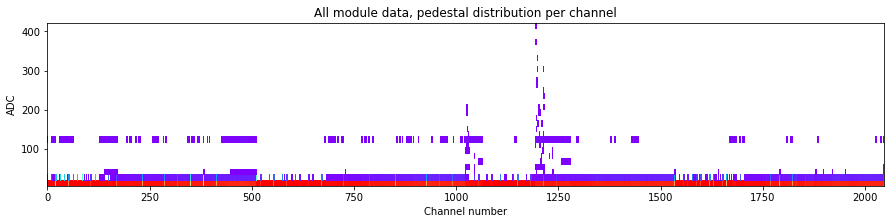

In [25]:
data = dataset.dfh.df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30], cmin=1)
axe.set_title('All module data, pedestal distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

There are some values that are bumping the scope of the histogram. lets zoom to the bottom part

Text(0, 0.5, 'ADC')

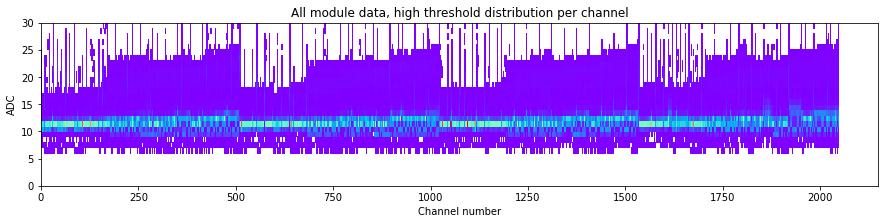

In [26]:
data = dataset.dfh.df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30], range=[[0,2148],[0,30]], cmin=1)
axe.set_title('All module data, high threshold distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

In [27]:
weird = (data > 25).sum(axis=1)>10

In [28]:
weird_hits = dataset.dfh.df.loc[weird.index[weird==True],:]

In [29]:
dfw = dataset.dfh.df.copy()

In [30]:
dfw.iloc[:,9:] = (data>25)

In [31]:
dfw.groupby(["datetime"]).sum().iloc[:,2:].sum(axis=0)

channel0        2
channel1        0
channel2        0
channel3        0
channel4        0
               ..
channel2043     1
channel2044     0
channel2045     2
channel2046    11
channel2047    99
Length: 2048, dtype: int64

In [32]:
dfw.groupby(["sensor"]).sum().iloc[:,2:].sum(axis=1)

sensor
0.0       45
1.0       18
2.0      128
3.0       46
4.0       95
        ... 
101.0      0
102.0     28
103.0      8
104.0     47
105.0      6
Length: 84, dtype: int64

we can see that adc oscillates somewhat around value of 10-12. Those data are to general, we need to separate R type sensor and phi type

### R-type

Text(0, 0.5, 'ADC')

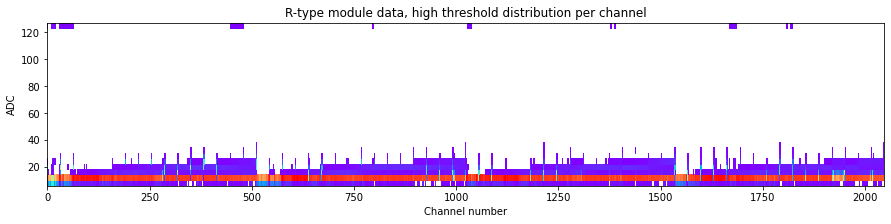

In [33]:
data = dataset.dfh['R'].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30],cmin=1)
axe.set_title('R-type module data, high threshold distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

### Phi - type

Text(0, 0.5, 'ADC')

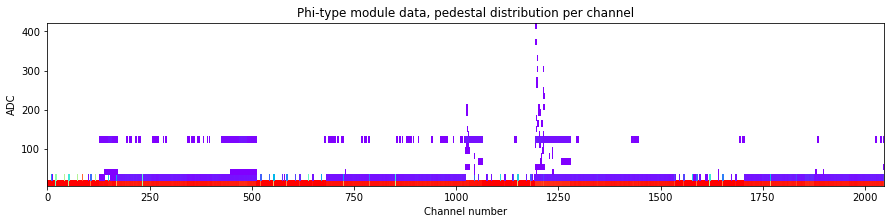

In [34]:
data = dataset.dfh['phi'].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30],cmin=1)
axe.set_title('Phi-type module data, pedestal distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

<ipython-input-35-7d3ef647b3d6>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


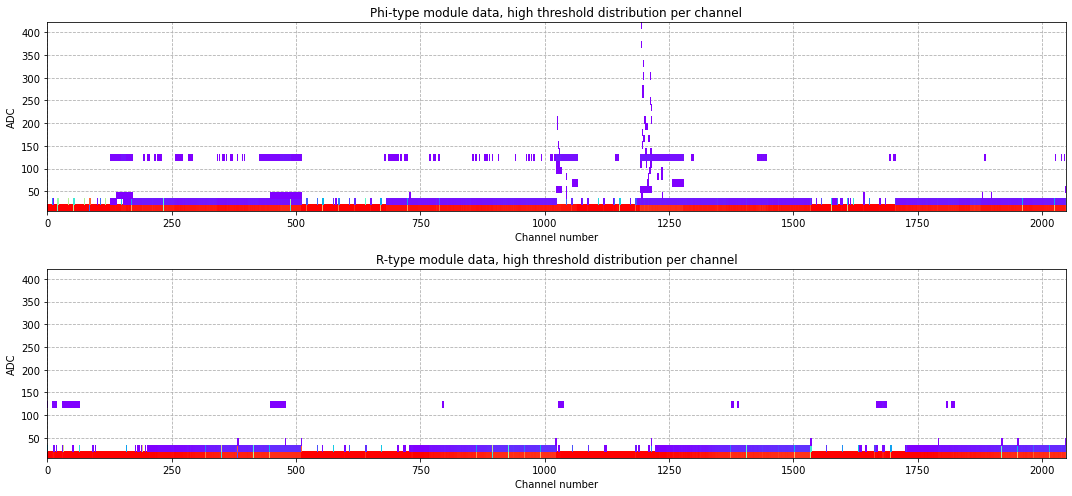

In [35]:
data = dataset.dfh['phi'].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(2,1,figsize=(15,7))
_, xedges, yedges, _  = axe[0].hist2d(px, py, bins=[2048,30],cmin=1)
data = dataset.dfh['R'].df.iloc[:,9:]
px, py = sensor_histogram(data)
_, xedges, yedges, _   = axe[1].hist2d(px, py,range=[[xedges[0],xedges[-1]],[yedges[0],yedges[-1]]], bins=[2048,30],cmin=1)
axe[1].grid(linestyle='dashed')
axe[1].set_axisbelow(True)
axe[0].grid(linestyle='dashed')
axe[0].set_axisbelow(True)
axe[0].set_title('Phi-type module data, high threshold distribution per channel')
axe[0].set_xlabel('Channel number')
axe[0].set_ylabel('ADC')
axe[1].set_title('R-type module data, high threshold distribution per channel')
axe[1].set_xlabel('Channel number')
axe[1].set_ylabel('ADC')

fig.tight_layout()
fig.savefig(plot_output/"P2-threshold-all-r-phi.png")
fig.show()

In both cases we can see that values oscillate around 10, but faint 'ghost-distribution' is visible.

## R-type, ghosting

To determine whats causing this ghosting, lets just inspect entries with values greater than 15.0

In [36]:
dfhr = dataset.dfh['R'].df
increased = dfhr.iloc[:,9:]>15.0

Lets check the sum of entriex exceeding 15 per sensor calibration

Text(0, 0.5, 'Number of occurances')

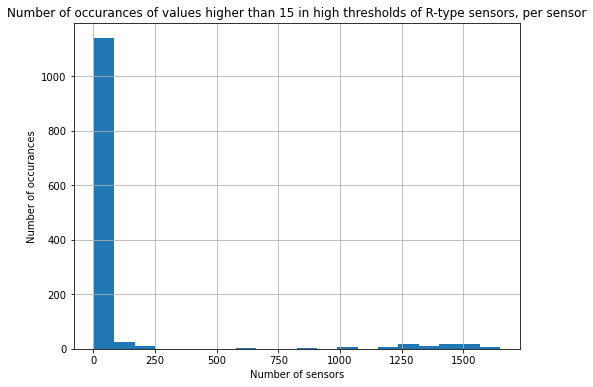

In [37]:
fig, axe = plt.subplots(1,1)
_ = increased.sum(axis=1).hist(bins=20, figsize=(8,6))
axe.set_title('Number of occurances of values higher than 15 in high thresholds of R-type sensors, per sensor')
axe.set_xlabel('Number of sensors')
axe.set_ylabel('Number of occurances')

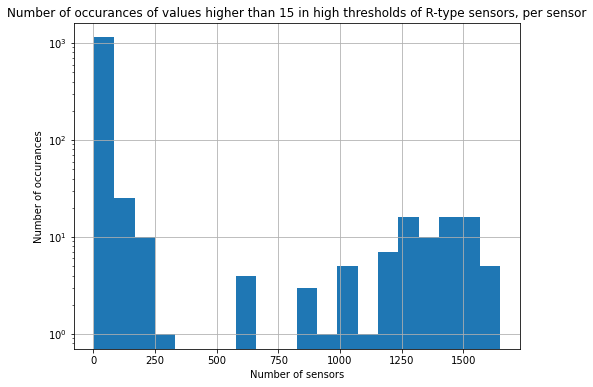

In [38]:
fig, axe = plt.subplots(1,1)
increased.sum(axis=1).hist(bins=20, log=True, figsize=(8,6))
axe.set_title('Number of occurances of values higher than 15 in high thresholds of R-type sensors, per sensor')
axe.set_xlabel('Number of sensors')
axe.set_ylabel('Number of occurances')
fig.savefig(plot_output/"P2-higher15-hist.png")

We can see that there are outliers with more than 400 entries that exceed that value, lets separate those entries.

In [39]:
high_values = dfhr[increased.sum(axis=1)>400]

And see at what dates did they occur

In [40]:
bad_calibration = high_values['datetime'].unique()
bad_calibration

array(['2012-07-30T00:00:00.000000000', '2012-08-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

Text(0, 0.5, 'ADC')

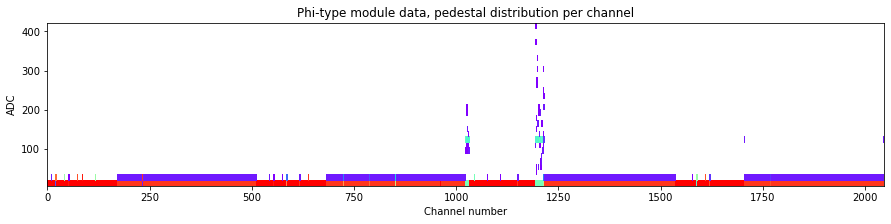

In [41]:
data = dataset.dfh['phi']['#67'].df
data = data.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30],cmin=1)
axe.set_title('Phi-type module data, pedestal distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

Those are the dates that correspond with callibration process errors.

lets look at the distributions per channel again, after excluding those dates

In [42]:
wrong = dataset.dfh.df[dataset.dfh.df['datetime'].isin(bad_calibration)]
other = dataset.dfh.df[~dataset.dfh.df['datetime'].isin(bad_calibration)]
wrong = DS.DatasetTree.from_df(wrong)
other = DS.DatasetTree.from_df(other)

#### R-type sensors for High threshold

Wrong

Text(0, 0.5, 'ADC')

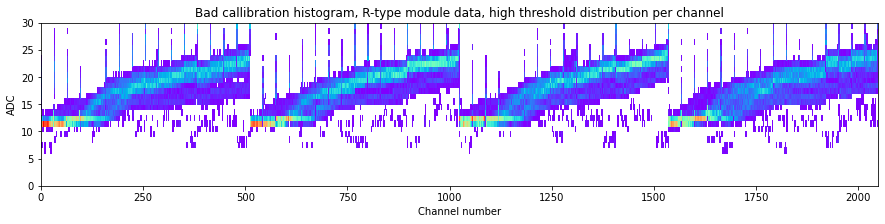

In [43]:
data = wrong['R'].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30], range=[[0,2048],[0,30]],cmin=1)
axe.set_title('Bad callibration histogram, R-type module data, high threshold distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

Good

Text(0, 0.5, 'ADC')

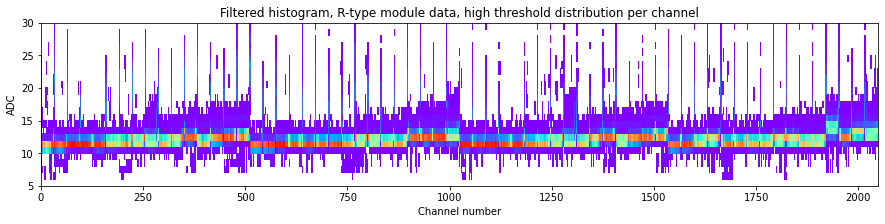

In [44]:
data = other['R'].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,25], range=[[0,2048],[5,30]],cmin=1)
axe.set_title('Filtered histogram, R-type module data, high threshold distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

Text(0.5, 0, 'ADC')

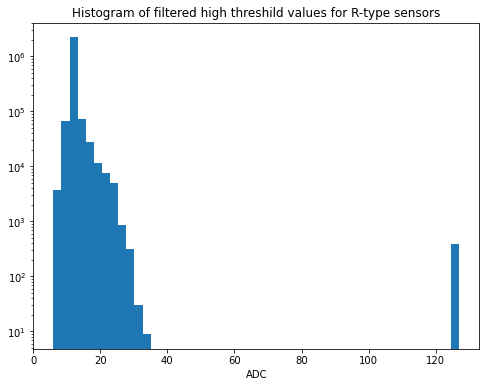

In [45]:
fig, axe = plt.subplots(1,1, figsize=(8,6))
_ = plt.hist(other['R'].df.iloc[:,9:].values.ravel(),bins=50, log=True)
axe.set_title('Histogram of filtered high threshild values for R-type sensors')
axe.set_xlabel('ADC')

In [46]:
data.mean().mean()

11.797230830808909

#### Phi-type for High threshold:

worng

Text(0, 0.5, 'ADC')

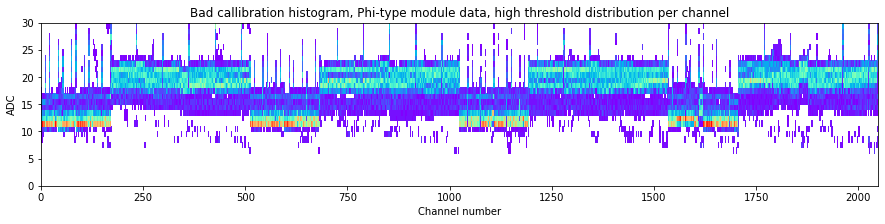

In [47]:
data = wrong['phi'].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30], range=[[0,2048],[0,30]],cmin=1)
axe.set_title('Bad callibration histogram, Phi-type module data, high threshold distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

good

Text(0, 0.5, 'ADC')

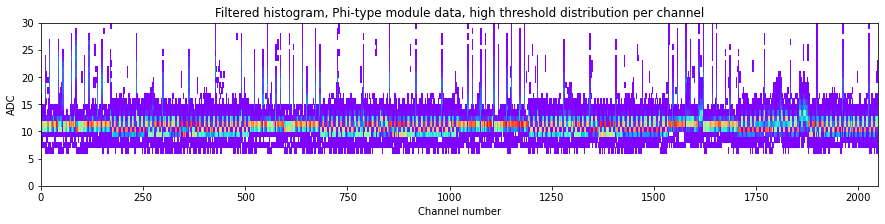

In [48]:
data = other['phi'].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30],  range=[[0,2048],[0,30]],cmin=1)
axe.set_title('Filtered histogram, Phi-type module data, high threshold distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

Text(0.5, 0, 'ADC')

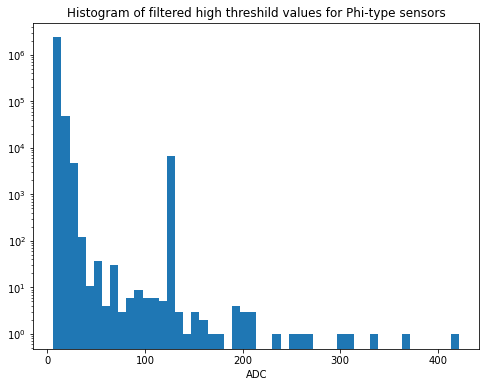

In [49]:
fig, axe = plt.subplots(1,1, figsize=(8,6))
_ = plt.hist(other['phi'].df.iloc[:,9:].values.ravel(),bins=50, log=True)
axe.set_title('Histogram of filtered high threshild values for Phi-type sensors')
axe.set_xlabel('ADC')

## Important !!
 - We see some faint peculiar distribution in some channels, in both good calibrations and bad
 - still, there are some high values, that are outside the scope of the plotsabove 

# Header cross-talk

those faint peculiar distributions are related to header cross talk, to take a better look at them we need to look at specific channels in modules

In [50]:
from sklearn.neighbors.kde import KernelDensity

/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [51]:
plotset = other
y = plotset['R']['#0']['channel0'].values.T[:, np.newaxis]
x = np.linspace(5, 30, 500)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.7).fit(y)
log_dens = kde.score_samples(x)
y = np.exp(log_dens)
p = figure(title="simple line example", plot_height=300, plot_width=600)
r = p.line(x[:,0], y, color="#2222aa", line_width=3)
def update(channel, bandwidth):
    y = plotset['R']['channel'+str(channel)].values.T[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(y)
    log_dens = kde.score_samples(x)
    y = np.exp(log_dens)
    r.data_source.data['y'] = y
    push_notebook()
show(p, notebook_handle=True)

In [52]:
interact(update, channel=(0,2047), bandwidth=(0.,1.,0.05))

interactive(children=(IntSlider(value=1023, description='channel', max=2047), FloatSlider(value=0.5, descripti…

<function __main__.update(channel, bandwidth)>

0, 32, 64, 96, 159, 191, 223, 255, 287, 319, 351, 383, 415, 447, 479, 511, 543, 575, 607, 639, 640!, 672, 704, 736, 768, 800, 832, 864, 896, 928, 960, 992, 1024, 1056, 1088, 1120, 1183, 1215, 1247, 1279, 1311, 1343, 1375, 1407, 1439, 1471?, 1503, 1535, 1567, 1599, 1631, 1663, 1664?, 1696, 1728, 1760, 1792, 1824, 1856, 1888, 1920, 1952, 1984, 2016

We used kernel density estimators to eleiminate binning problem. As we can see in interactive plot above, we cane separate the cahnnels that are experiencing header cross talk by calculating KDE peaks, with manually selected bandwith.

Below is small snippet allowing for channel per sensor analysis of distribution.

In [53]:
plotset = other
y = plotset['#0']['channel0'].values.T[:, np.newaxis]
x = np.linspace(5, 30, 500)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.7).fit(y)
log_dens = kde.score_samples(x)
y = np.exp(log_dens)
p = figure(title="simple line example", plot_height=300, plot_width=600)
r = p.line(x[:,0], y, color="#2222aa", line_width=3)
def update(sensor, channel, bandwidth):
    y = plotset[sensor]['channel'+str(channel)].values.T[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(y)
    log_dens = kde.score_samples(x)
    y = np.exp(log_dens)
    r.data_source.data['y'] = y
    push_notebook()
show(p, notebook_handle=True)

In [54]:
interact(update, sensor=DS.sensor_numbers, channel=(0,2047), bandwidth=(0.,1.,0.05))

interactive(children=(Dropdown(description='sensor', options=('#0', '#1', '#2', '#3', '#4', '#5', '#6', '#7', …

<function __main__.update(sensor, channel, bandwidth)>

In [55]:
plotset = other
y = plotset['#0']['channel0'].values.T[:, np.newaxis]
x = np.linspace(5, 30, 500)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.7).fit(y)
log_dens = kde.score_samples(x)
y = np.exp(log_dens)
p = figure(title="simple line example", plot_height=300, plot_width=600)
r = p.line(x[:,0], y, color="#2222aa", line_width=3)
def update(sensor, channel, bandwidth):
    y = plotset[sensor]['channel'+str(channel)].values.T[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(y)
    log_dens = kde.score_samples(x)
    y = np.exp(log_dens)
    r.data_source.data['y'] = y
    push_notebook()
show(p, notebook_handle=True)

In [56]:
plotset = other['R'].df.iloc[:,9:]

In [57]:
def calculate_column_peak(df):
    y = df.values.T[:, np.newaxis]
    x = np.linspace(5, 30, 500)[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=0.45).fit(y)
    log_dens = kde.score_samples(x)
    y = np.exp(log_dens)
    return x[np.argmax(y)][0]

In [58]:
peakz = plotset.aggregate(calculate_column_peak)

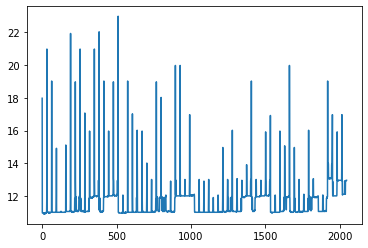

In [59]:
plt.plot(peakz.values)

# Trending of thresholds

In [60]:
from sklearn import linear_model
plotset = other['R']["#0"].df
y = plotset['channel0']
x = plotset['datetime']
model = linear_model.LinearRegression()
modelx = x.values[:,np.newaxis]
modely = y.values[:,np.newaxis]
model.fit(modelx.astype(np.float64), modely)
Y_pred = model.predict(modelx.astype(np.float64))
p = figure(title="Individual channel pedestal values of sensor in time, with linear trend", plot_height=300, plot_width=600)
r = p.circle(x, y, color="#2222aa", line_width=3)
r2 = p.line(x, Y_pred[:,0], color="green", line_width=3)
from bokeh.models import DatetimeTickFormatter
p.xaxis.formatter=DatetimeTickFormatter(
        hours=["%d %B %Y"],
        days=["%d %B %Y"],
        months=["%d %B %Y"],
        years=["%d %B %Y"],
    )
p.xaxis.major_label_orientation = 3.1415/4
def update2(sensor, channel):
    model = linear_model.LinearRegression()
    modelx = x.values[:,np.newaxis]
    plotset = other['R'][sensor].df
    y = plotset['channel'+str(channel)]
    modely = y.values[:,np.newaxis]
    model.fit(modelx.astype(np.float64), modely)
    Y_pred = model.predict(modelx.astype(np.float64))
    r.data_source.data['y'] = y
    r2.data_source.data['y'] = Y_pred[:,0]
    push_notebook()
show(p, notebook_handle=True)

In [61]:
interact(update2, sensor=other["R"].df.sensor_number.unique(), channel=(0,2047))

interactive(children=(Dropdown(description='sensor', options=('#0', '#1', '#2', '#3', '#4', '#5', '#6', '#7', …

<function __main__.update2(sensor, channel)>

In [62]:
from sklearn.preprocessing import normalize

def get_coef(x,y):
    model = linear_model.LinearRegression()
    modely = y.values[:,np.newaxis]
    modelx = x[:,np.newaxis]
    model.fit(modelx, modely)
    return model.coef_[0]

def get_df_coef(df):
    time = df['datetime'].values
    time = (time-time.min())/np.timedelta64(1,'D')
    ret = []
    for column in df.iloc[:,9:]:
        y=df[column]
        coef = get_coef(time, y)
        ret.append(coef)
    return np.array(ret).T

In [63]:
group = other.df.groupby(['sensor_number'])
results = {}
for groupname, data in group:
    results[groupname] = get_df_coef(data)[0]

In [64]:
coefs = pd.DataFrame.from_dict(results,orient='index')
coefs.columns = [ "channel"+str(i) for i in list(coefs.columns)]
coefs = coefs.reset_index()
coefs = coefs.rename(columns={'index':'sensor_number'})

data = dataset.dfp.df
data = data.drop(data.iloc[:,9:].columns , axis=1)
data = data.drop(['datetime'], axis=1)
data = data.reset_index(drop=True)
dara = data.drop_duplicates()
total_coefs = pd.merge(dara, coefs, on='sensor_number')

Text(0, 0.5, 'ADC')

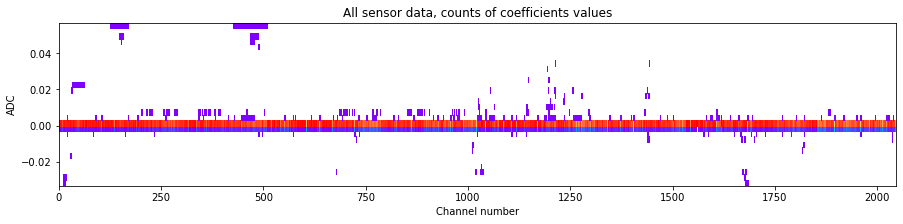

In [65]:

data = total_coefs.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30],cmin=1)
axe.set_title('All sensor data, counts of coefficients values')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

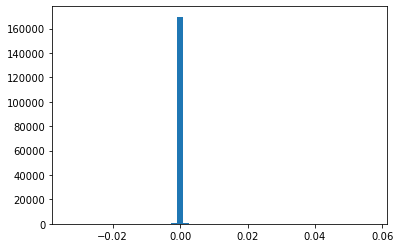

In [66]:
_ = plt.hist(total_coefs.iloc[:,9:].values.ravel(),bins=50)

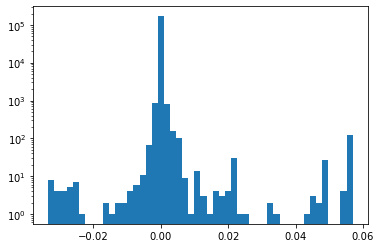

In [67]:
_ = plt.hist(total_coefs.iloc[:,9:].values.ravel(),bins=50,log=True)

Lets inspect this

In [68]:
filtered = total_coefs.iloc[:,9:].abs()>=0.02

In [69]:
filtered.columns[filtered.sum()!=0]

Index(['channel11', 'channel12', 'channel13', 'channel14', 'channel15',
       'channel18', 'channel33', 'channel34', 'channel35', 'channel36',
       ...
       'channel1675', 'channel1677', 'channel1679', 'channel1680',
       'channel1681', 'channel1682', 'channel1683', 'channel1684',
       'channel1685', 'channel1686'],
      dtype='object', length=190)

In [70]:
total_coefs[filtered.sum(axis=1)!=0].sensor_number

6      #6
11    #11
17    #17
27    #27
38    #38
45    #67
60    #82
62    #84
75    #97
77    #99
Name: sensor_number, dtype: object

Text(0, 0.5, 'ADC')

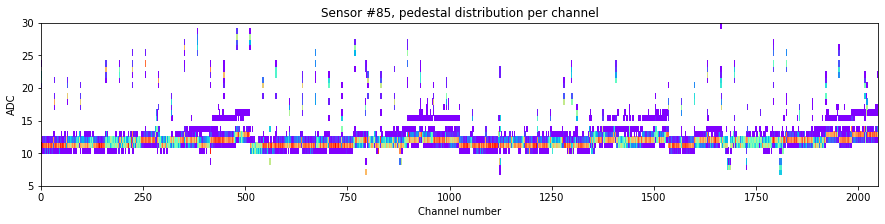

In [71]:
data = other["#6"].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30], range=[[0,2048],[5,30]],cmin=1)
axe.set_title('Sensor #85, pedestal distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

Text(0, 0.5, 'ADC')

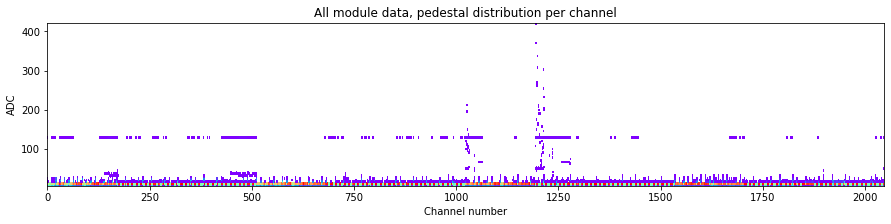

In [72]:
data = other.df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,100],cmin=1)
axe.set_title('All module data, pedestal distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

In [73]:
dfhp = dataset.dfh['phi'].df
super_inc = dfhp.iloc[:,9:]>300.0

In [74]:
super_high_values = dfhp[super_inc.sum(axis=1)>1]

In [75]:
super_high_values

type  sensor   datetime  Zmod slot_label mod_nr  mod_type  \
4127  hit_threshold    67.0 2016-11-07  -130      VL02R  mod_3  VELO_phi   
4130  hit_threshold    67.0 2016-11-11  -130      VL02R  mod_3  VELO_phi   

     sensor_type sensor_number  channel0  ...  channel2038  channel2039  \
4127         phi           #67      12.0  ...         10.0         12.0   
4130         phi           #67      12.0  ...         10.0         12.0   

      channel2040  channel2041  channel2042  channel2043  channel2044  \
4127         10.0         12.0         10.0         12.0         10.0   
4130         10.0         12.0         10.0         12.0         10.0   

      channel2045  channel2046  channel2047  
4127          7.0         11.0         12.0  
4130          7.0         11.0         12.0  

[2 rows x 2057 columns]

<ipython-input-76-7d3ef647b3d6>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


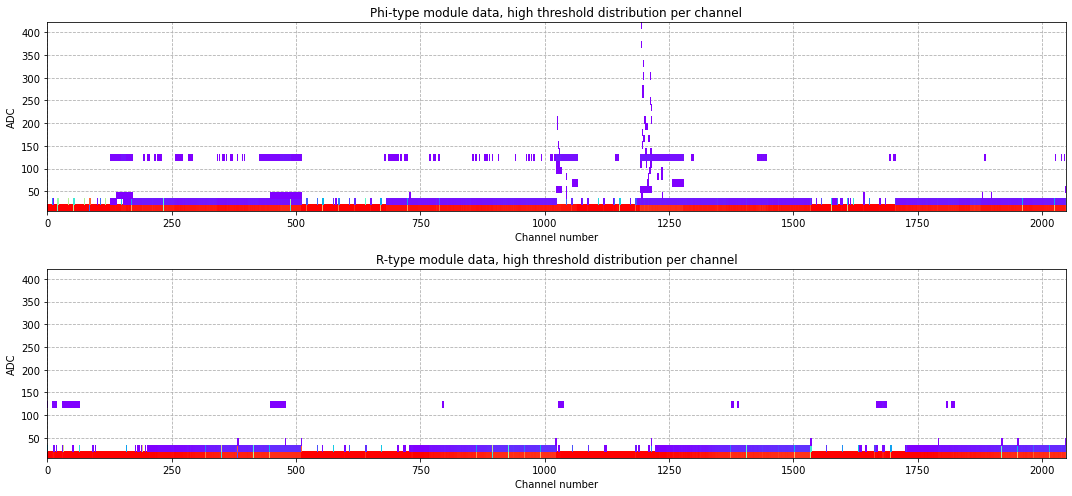

In [76]:
data = dataset.dfh['phi'].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(2,1,figsize=(15,7))
_, xedges, yedges, _  = axe[0].hist2d(px, py, bins=[2048,30],cmin=1)
data = dataset.dfh['R'].df.iloc[:,9:]
px, py = sensor_histogram(data)
_, xedges, yedges, _   = axe[1].hist2d(px, py,range=[[xedges[0],xedges[-1]],[yedges[0],yedges[-1]]], bins=[2048,30],cmin=1)
axe[1].grid(linestyle='dashed')
axe[1].set_axisbelow(True)
axe[0].grid(linestyle='dashed')
axe[0].set_axisbelow(True)
axe[0].set_title('Phi-type module data, high threshold distribution per channel')
axe[0].set_xlabel('Channel number')
axe[0].set_ylabel('ADC')
axe[1].set_title('R-type module data, high threshold distribution per channel')
axe[1].set_xlabel('Channel number')
axe[1].set_ylabel('ADC')

fig.tight_layout()
fig.savefig(plot_output/"P2-threshold-all-r-phi.png")
fig.show()

<ipython-input-77-12532c907822>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


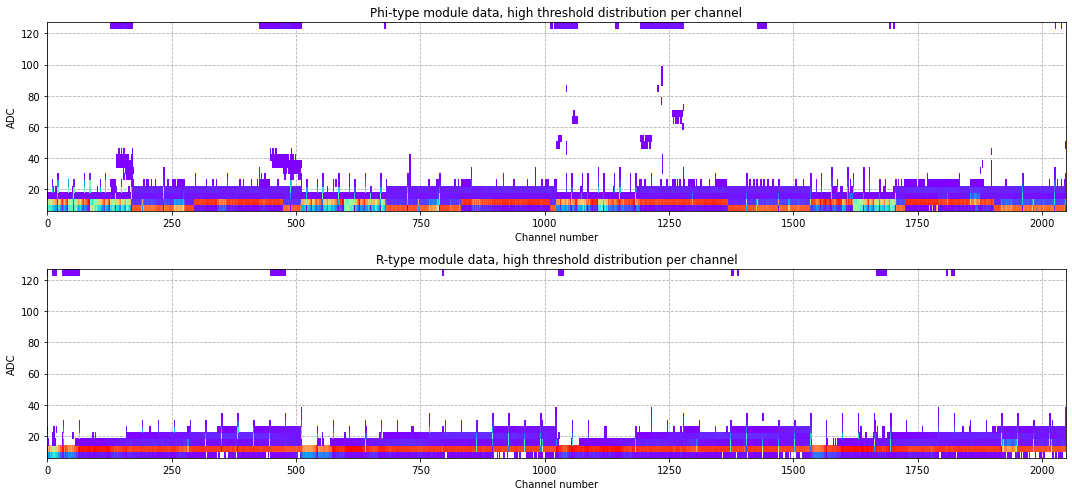

In [77]:
exclusion = dataset.dfh['phi'].df
data = exclusion[(exclusion['datetime'] != '2016-11-07') & (exclusion['datetime'] != '2016-11-11') & (exclusion['sensor'] != 67.)]


data = data.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(2,1,figsize=(15,7))
_, xedges, yedges, _  = axe[0].hist2d(px, py, bins=[2048,30],cmin=1)
data = dataset.dfh['R'].df.iloc[:,9:]
px, py = sensor_histogram(data)
_, xedges, yedges, _   = axe[1].hist2d(px, py,range=[[xedges[0],xedges[-1]],[yedges[0],yedges[-1]]], bins=[2048,30],cmin=1)
axe[1].grid(linestyle='dashed')
axe[1].set_axisbelow(True)
axe[0].grid(linestyle='dashed')
axe[0].set_axisbelow(True)
axe[0].set_title('Phi-type module data, high threshold distribution per channel')
axe[0].set_xlabel('Channel number')
axe[0].set_ylabel('ADC')
axe[1].set_title('R-type module data, high threshold distribution per channel')
axe[1].set_xlabel('Channel number')
axe[1].set_ylabel('ADC')

fig.tight_layout()
fig.savefig(plot_output/"P2-threshold-all-r-phi-no-400.png")
fig.show()

<ipython-input-78-ce369a6c6951>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


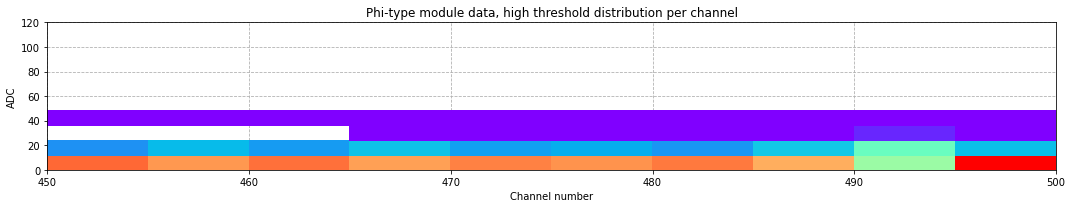

In [78]:
exclusion = dataset.dfh['phi'].df
data = exclusion[(exclusion['datetime'] != '2016-11-07') & (exclusion['datetime'] != '2016-11-11') & (exclusion['sensor'] != 67.)]


data = data.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_, xedges, yedges, _  = axe.hist2d(px, py,range=[[450,500],[0,120]],cmin=1)
data = dataset.dfh['R'].df.iloc[:,9:]
px, py = sensor_histogram(data)

axe.grid(linestyle='dashed')
axe.set_axisbelow(True)
axe.set_title('Phi-type module data, high threshold distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

fig.tight_layout()
fig.savefig(plot_output/"P2-phi-no-400.png")
fig.show()

In [79]:
dfhp = dataset.dfh['phi'].df
inc = dfhp[((dfhp.iloc[:,499:509]<100.0).sum(axis=1)>1) & ((dfhp.iloc[:,499:509]>30.0).sum(axis=1)>1)]

In [80]:
inc

type  sensor   datetime  Zmod slot_label  mod_nr mod_type  \
6788  hit_threshold    97.0 2012-07-30   450      VL19R  mod_33   VELO_R   
6791  hit_threshold    97.0 2012-08-01   450      VL19R  mod_33   VELO_R   
6794  hit_threshold    97.0 2012-08-02   450      VL19R  mod_33   VELO_R   

     sensor_type sensor_number  channel0  ...  channel2038  channel2039  \
6788         phi           #97      11.0  ...         18.0         19.0   
6791         phi           #97      11.0  ...         19.0         19.0   
6794         phi           #97      13.0  ...         12.0         13.0   

      channel2040  channel2041  channel2042  channel2043  channel2044  \
6788         19.0         18.0         18.0         19.0         19.0   
6791         18.0         18.0         18.0         19.0         18.0   
6794         12.0         13.0         12.0         13.0         12.0   

      channel2045  channel2046  channel2047  
6788         19.0         19.0         21.0  
6791         19.0         19.0         21.0  
6794         13.0         12.0         13.0  

[3 rows x 2057 columns]

In [81]:
xedges

array([450., 455., 460., 465., 470., 475., 480., 485., 490., 495., 500.])

<ipython-input-107-a96ad1bd5290>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


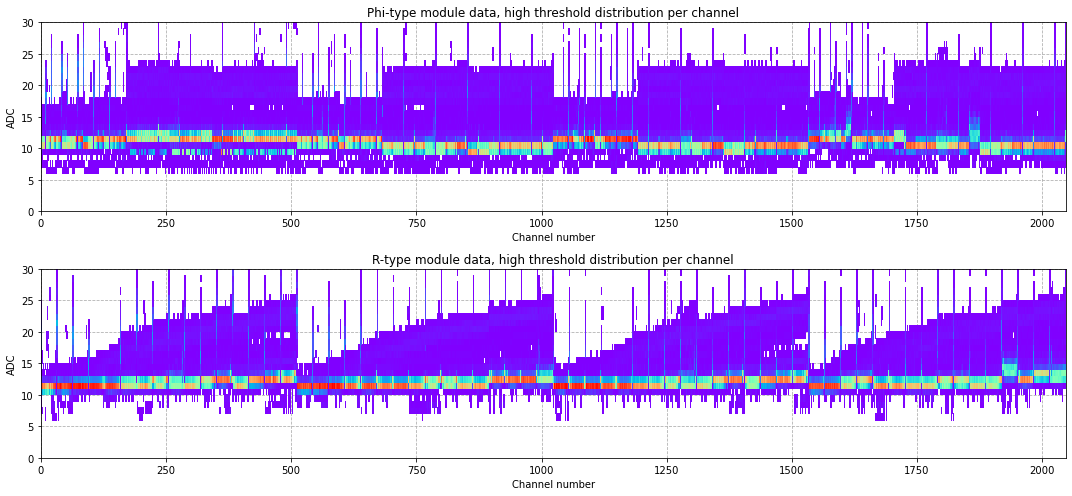

In [107]:
data = dataset.dfh['phi'].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(2,1,figsize=(15,7))
_, xedges, yedges, _  = axe[0].hist2d(px, py,range=[[0,2047],[0,30]], bins=[2048,30],cmin=1)
data = dataset.dfh['R'].df.iloc[:,9:]
px, py = sensor_histogram(data)
_, xedges, yedges, _   = axe[1].hist2d(px, py,range=[[0,2047],[0,30]], bins=[2048,30],cmin=1)
axe[1].grid(linestyle='dashed')
axe[1].set_axisbelow(True)
axe[0].grid(linestyle='dashed')
axe[0].set_axisbelow(True)
axe[0].set_title('Phi-type module data, high threshold distribution per channel')
axe[0].set_xlabel('Channel number')
axe[0].set_ylabel('ADC')
axe[1].set_title('R-type module data, high threshold distribution per channel')
axe[1].set_xlabel('Channel number')
axe[1].set_ylabel('ADC')

fig.tight_layout()
fig.savefig(plot_output/"P2-threshold-all-zoom.png")
fig.show()

<ipython-input-108-ca334269c19e>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


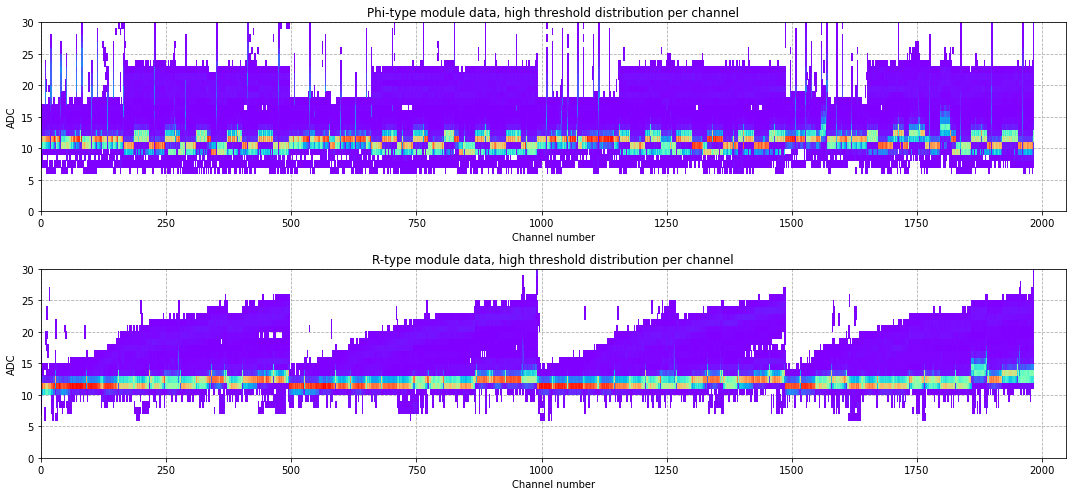

In [108]:
data = dataset.dfh['phi'].df.iloc[:,9:]
data = remove_anomalies(data, cut_val=None)
px, py = sensor_histogram(data)
fig, axe = plt.subplots(2,1,figsize=(15,7))
_, xedges, yedges, _  = axe[0].hist2d(px, py,range=[[0,2047],[0,30]], bins=[2048,30],cmin=1)
data = dataset.dfh['R'].df.iloc[:,9:]
data = remove_anomalies(data, cut_val=None)
px, py = sensor_histogram(data)
_, xedges, yedges, _   = axe[1].hist2d(px, py,range=[[0,2047],[0,30]], bins=[2048,30],cmin=1)
axe[1].grid(linestyle='dashed')
axe[1].set_axisbelow(True)
axe[0].grid(linestyle='dashed')
axe[0].set_axisbelow(True)
axe[0].set_title('Phi-type module data, high threshold distribution per channel')
axe[0].set_xlabel('Channel number')
axe[0].set_ylabel('ADC')
axe[1].set_title('R-type module data, high threshold distribution per channel')
axe[1].set_xlabel('Channel number')
axe[1].set_ylabel('ADC')

fig.tight_layout()
fig.savefig(plot_output/"P2-threshold-all-zoom-nohc.png")
fig.show()

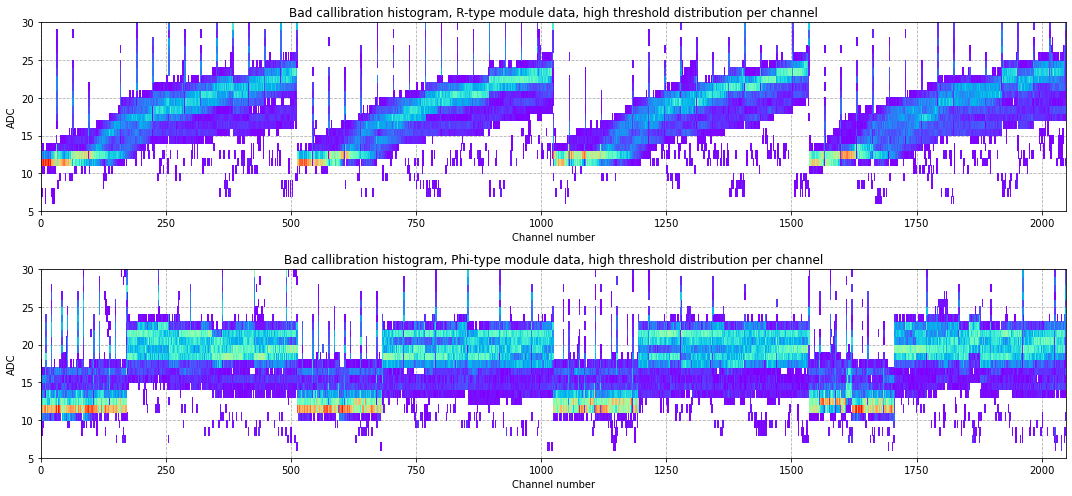

In [83]:
data = wrong['R'].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(2,1,figsize=(15,7))
_ = axe[0].hist2d(px, py, bins=[2048,25], range=[[0,2048],[5,30]],cmin=1)
axe[0].set_title('Bad callibration histogram, R-type module data, high threshold distribution per channel')
axe[0].set_xlabel('Channel number')
axe[0].set_ylabel('ADC')
data = wrong['phi'].df.iloc[:,9:]
px, py = sensor_histogram(data)

_ = axe[1].hist2d(px, py, bins=[2048,25], range=[[0,2048],[5,30]],cmin=1)
axe[1].set_title('Bad callibration histogram, Phi-type module data, high threshold distribution per channel')
axe[1].set_xlabel('Channel number')
axe[1].set_ylabel('ADC')
axe[1].grid(linestyle='dashed')
axe[1].set_axisbelow(True)
axe[0].grid(linestyle='dashed')
axe[0].set_axisbelow(True)
fig.tight_layout()

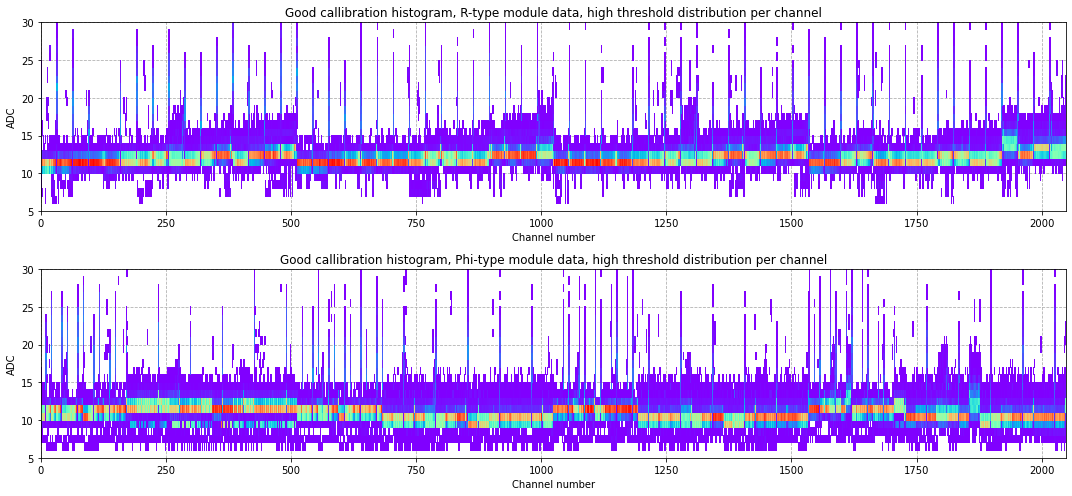

In [84]:
data = other['R'].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(2,1,figsize=(15,7))
_ = axe[0].hist2d(px, py, bins=[2048,25], range=[[0,2048],[5,30]],cmin=1)
axe[0].set_title('Good callibration histogram, R-type module data, high threshold distribution per channel')
axe[0].set_xlabel('Channel number')
axe[0].set_ylabel('ADC')
data = other['phi'].df.iloc[:,9:]
px, py = sensor_histogram(data)

_ = axe[1].hist2d(px, py, bins=[2048,25], range=[[0,2048],[5,30]],cmin=1)
axe[1].set_title('Good callibration histogram, Phi-type module data, high threshold distribution per channel')
axe[1].set_xlabel('Channel number')
axe[1].set_ylabel('ADC')
axe[1].grid(linestyle='dashed')
axe[1].set_axisbelow(True)
axe[0].grid(linestyle='dashed')
axe[0].set_axisbelow(True)
fig.tight_layout()

Good

Text(0, 0.5, 'ADC')

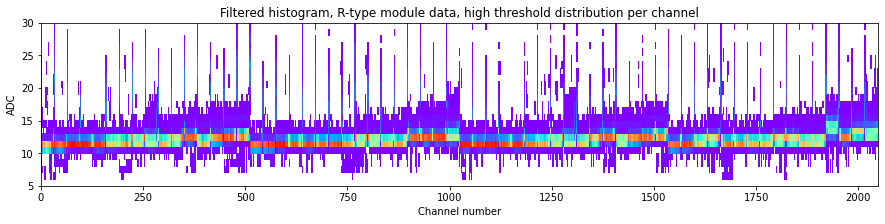

In [85]:
data = other['R'].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,25], range=[[0,2048],[5,30]],cmin=1)
axe.set_title('Filtered histogram, R-type module data, high threshold distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

good

Text(0, 0.5, 'ADC')

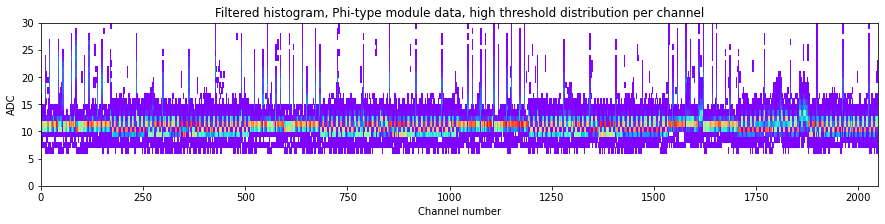

In [86]:
data = other['phi'].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30], range=[[0,2048],[0,30]],cmin=1)
axe.set_title('Filtered histogram, Phi-type module data, high threshold distribution per channel')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')

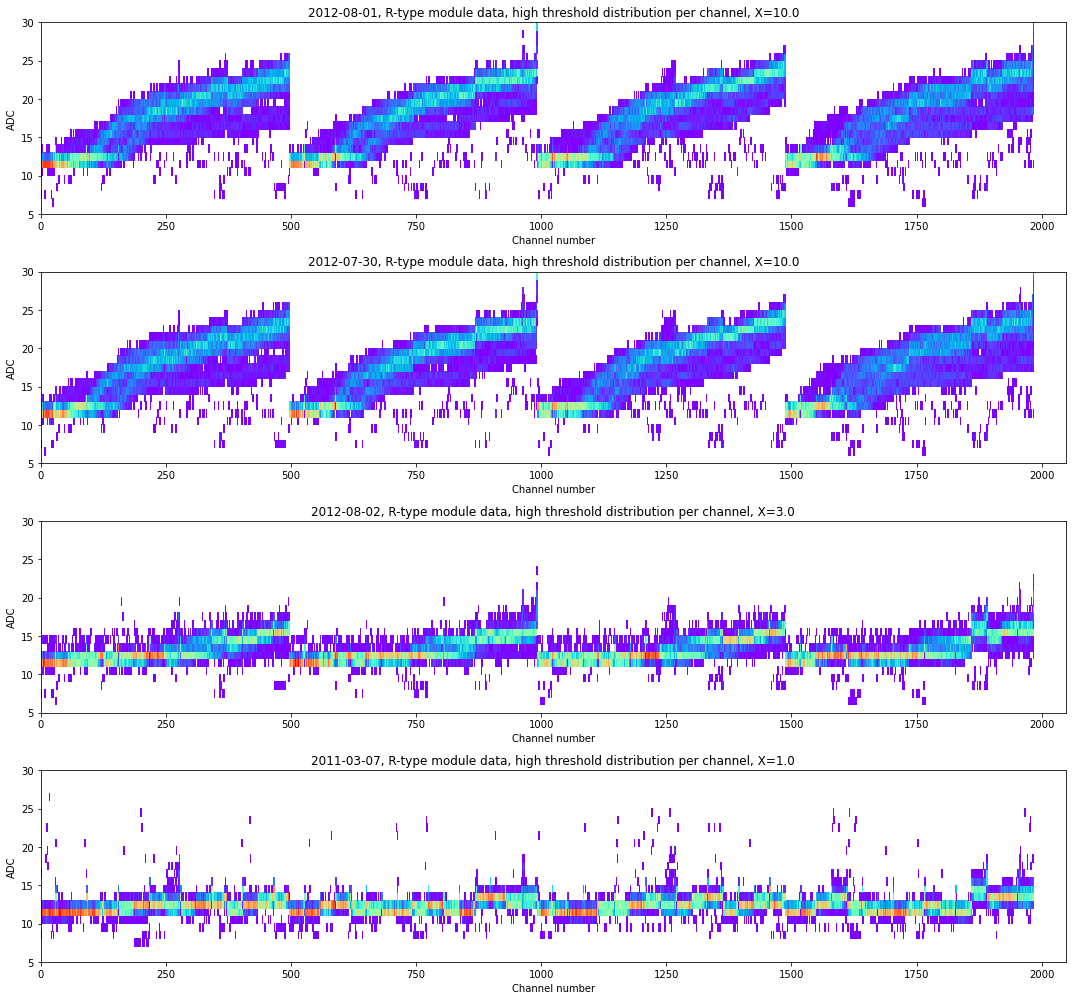

In [105]:
from processing import BADCALS
from processing import remove_anomalies
fig, axe = plt.subplots(4,1,figsize=(15,14))
for i,(date, value) in enumerate(reversed(BADCALS.items())):
    data = DS.DatasetTree.from_df(dataset.dfh.df[dataset.dfh.df['datetime'] == date])
    data = data['R'].df.iloc[:,9:]
    data = remove_anomalies(data, cut_val=None)
    px, py = sensor_histogram(data)
    _ = axe[i].hist2d(px, py, bins=[2048,25], range=[[0,2048],[5,30]],cmin=1)
    axe[i].set_title('{}, R-type module data, high threshold distribution per channel, X={}'.format(date,value))
    axe[i].set_xlabel('Channel number')
    axe[i].set_ylabel('ADC')

fig.tight_layout()
fig.savefig(plot_output/"P2-all-bad-cals-R.png")

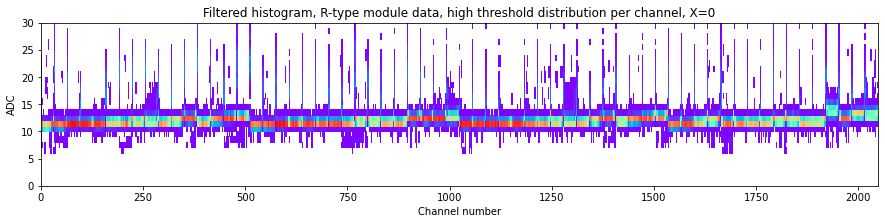

In [100]:
data = DS.DatasetTree.from_df(dataset.dfh.df[~dataset.dfh.df['datetime'].isin(BADCALS.keys())])
data = data['R'].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30], range=[[0,2048],[0,30]],cmin=1)
axe.set_title('Filtered histogram, R-type module data, high threshold distribution per channel, X=0')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')
fig.savefig(plot_output/"P2-only-good-R.png")

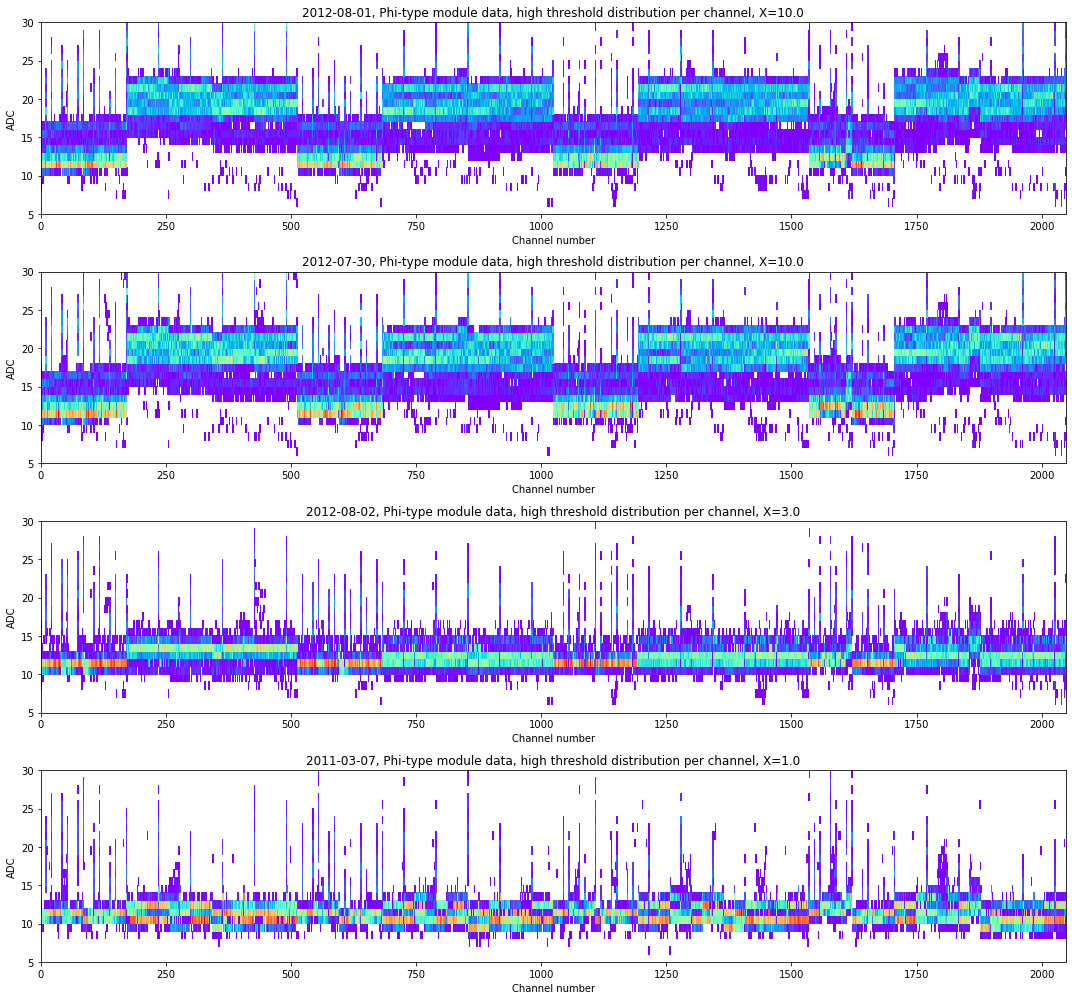

In [103]:
from processing import BADCALS
fig, axe = plt.subplots(4,1,figsize=(15,14))
for i,(date, value) in enumerate(reversed(BADCALS.items())):
    data = DS.DatasetTree.from_df(dataset.dfh.df[dataset.dfh.df['datetime'] == date])
    data = data['phi'].df.iloc[:,9:]
    px, py = sensor_histogram(data)
    _ = axe[i].hist2d(px, py, bins=[2048,25], range=[[0,2048],[5,30]],cmin=1)
    axe[i].set_title('{}, Phi-type module data, high threshold distribution per channel, X={}'.format(date,value))
    axe[i].set_xlabel('Channel number')
    axe[i].set_ylabel('ADC')

fig.tight_layout()
fig.savefig(plot_output/"P2-all-bad-cals-phi.png")

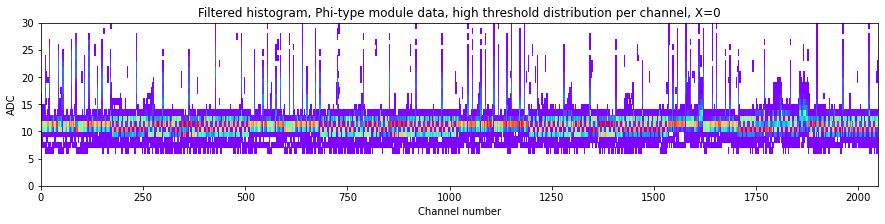

In [104]:
data = DS.DatasetTree.from_df(dataset.dfh.df[~dataset.dfh.df['datetime'].isin(BADCALS.keys())])
data = data['phi'].df.iloc[:,9:]
px, py = sensor_histogram(data)
fig, axe = plt.subplots(1,1,figsize=(15,3))
_ = plt.hist2d(px, py, bins=[2048,30], range=[[0,2048],[0,30]],cmin=1)
axe.set_title('Filtered histogram, Phi-type module data, high threshold distribution per channel, X=0')
axe.set_xlabel('Channel number')
axe.set_ylabel('ADC')
fig.savefig(plot_output/"P2-only-good-phi.png")